# Notebook 11 — Top Models Retraining & Usage Demo

This notebook retrains the top-performing models using the NASA Kepler dataset, fits a single NASA standard scaler, evaluates model performance, and demonstrates realistic planet-level predictions using identifiers.

Key principles:
- One scaler fitted on training data only
- Same preprocessing for training and usage
- Predictions mapped back to planet names

## Section 1 - Import necessary libraries and set paths

In [12]:
# Import
import pandas as pd
import numpy as np
import joblib
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    ExtraTreesClassifier
)
from sklearn.neural_network import MLPClassifier

In [ ]:
DATA_PATH = "../data/processed/feature_engineered_data.csv"
df = pd.read_csv(DATA_PATH)

print("Dataset shape:", df.shape)
print(df.head())

Dataset shape: (9564, 32)
   koi_score  koi_fpflag_nt  koi_fpflag_ss  koi_fpflag_co  koi_fpflag_ec  \
0      1.000            0.0            0.0            0.0            0.0   
1      0.969            0.0            0.0            0.0            0.0   
2      0.000            0.0            1.0            0.0            0.0   
3      0.000            0.0            1.0            0.0            0.0   
4      1.000            0.0            0.0            0.0            0.0   

   koi_time0bk  koi_impact  koi_tce_plnt_num  koi_steff  koi_slogg  ...  \
0   170.538750       0.146               1.0     5455.0      4.467  ...   
1   162.513840       0.586               2.0     5455.0      4.467  ...   
2   175.850252       0.969               1.0     5853.0      4.544  ...   
3   170.307565       1.276               1.0     5805.0      4.564  ...   
4   171.595550       0.701               1.0     6031.0      4.438  ...   

   koi_period_log  koi_duration_log  koi_depth_log  koi_prad_log  

## Section 2 - Check for NA values and deal with them

In [2]:
print(df["koi_disposition"].dtype)
print(df["koi_disposition"].value_counts())

int64
koi_disposition
2    5023
1    2293
0    2248
Name: count, dtype: int64


In [3]:
X = df.drop(columns=["koi_disposition"])
y_encoded = df["koi_disposition"].astype(int)

print(X.shape)
print(y_encoded.shape)

(9564, 31)
(9564,)


## Section 3 - Re-Training

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y_encoded,
    test_size=0.2,
    stratify=y_encoded,
    random_state=42
)

In [ ]:
# Fit NASA standard scaler on TRAINING DATA ONLY
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save the correct scaler (overwrite old one)
MODELS_PATH = Path("../models")
joblib.dump(scaler, MODELS_PATH / "nasa_standard_scaler.pkl")

print("NASA standard scaler fitted and saved.")
print("Number of features:", X_train.shape[1])

NASA standard scaler fitted and saved.
Number of features: 31


## Section 4 - Import the top 5 most accurate models (The accuracy was from notebook 09)

In [13]:
models = {
    "Logistic Regression": joblib.load(MODELS_PATH / "baseline_logistic_regression.pkl"),
    "Random Forest": joblib.load(MODELS_PATH / "random_forest_model.pkl"),
    "Gradient Boosting": joblib.load(MODELS_PATH / "gradient_boosting_model.pkl"),
    "Extra Trees": joblib.load(MODELS_PATH / "extra_trees.pkl"),
    "MLP Neural Network": joblib.load(MODELS_PATH / "mlp_neural_network_model.pkl")
}

In [14]:
# X already exists (engineered features)
X_usage = X.copy()

# Load the scaler that was FIT in this notebook
scaler = joblib.load(MODELS_PATH / "nasa_standard_scaler.pkl")

# Scaled version (for LR + MLP)
X_usage_scaled = scaler.transform(X_usage)

In [15]:
# Human-readable labels
LABEL_MAP = {
    0: "FALSE POSITIVE",
    1: "CANDIDATE",
    2: "CONFIRMED"
}

In [16]:
def predict_with_model(model, X_raw, X_scaled, needs_scaling):
    if needs_scaling:
        preds = model.predict(X_scaled)
        conf = model.predict_proba(X_scaled).max(axis=1)
    else:
        preds = model.predict(X_raw)
        conf = model.predict_proba(X_raw).max(axis=1)
    return preds, conf

## Section 5 - Run and evaluate the top 5 models

In [17]:
# Run predictions for ALL top-5 models
results = pd.DataFrame()

for model_name, model in models.items():

    needs_scaling = model_name in [
        "Logistic Regression",
        "MLP Neural Network"
    ]

    preds, conf = predict_with_model(
        model,
        X_usage,
        X_usage_scaled,
        needs_scaling
    )

    results[f"{model_name}_prediction"] = [LABEL_MAP[p] for p in preds]
    results[f"{model_name}_confidence"] = conf

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 400 out of 400 | elapsed:    0.0s finished
c:\Users\ibaan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
c:\Users\ibaan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


In [19]:
# Attach true labels (for verification)
results["True_Label"] = y_encoded.map(LABEL_MAP)
results.head(10)

,Logistic Regression_prediction,Logistic Regression_confidence,Random Forest_prediction,Random Forest_confidence,Gradient Boosting_prediction,Gradient Boosting_confidence,Extra Trees_prediction,Extra Trees_confidence,MLP Neural Network_prediction,MLP Neural Network_confidence,True_Label
0,CANDIDATE,0.803824,CANDIDATE,0.975,CANDIDATE,0.912047,CANDIDATE,1.0000,FALSE POSITIVE,0.720901,CANDIDATE
1,CANDIDATE,0.804198,CANDIDATE,0.945,CANDIDATE,0.941218,CANDIDATE,1.0000,FALSE POSITIVE,0.558059,CANDIDATE
2,CONFIRMED,0.964566,CONFIRMED,0.995,CONFIRMED,0.993877,CONFIRMED,1.0000,CANDIDATE,0.497019,CONFIRMED
3,CONFIRMED,0.981440,CONFIRMED,0.995,CONFIRMED,0.998050,CONFIRMED,1.0000,CANDIDATE,0.515911,CONFIRMED
4,CANDIDATE,0.598229,CANDIDATE,0.930,CANDIDATE,0.843760,CANDIDATE,1.0000,FALSE POSITIVE,0.748281,CANDIDATE
5,CANDIDATE,0.808914,CANDIDATE,0.925,CANDIDATE,0.926203,CANDIDATE,1.0000,FALSE POSITIVE,0.605401,CANDIDATE
6,CANDIDATE,0.778291,CANDIDATE,0.930,CANDIDATE,0.938560,CANDIDATE,1.0000,FALSE POSITIVE,0.634770,CANDIDATE
7,CANDIDATE,0.560329,CANDIDATE,0.800,CANDIDATE,0.764497,CANDIDATE,1.0000,FALSE POSITIVE,0.579588,CANDIDATE
8,CONFIRMED,0.999976,CONFIRMED,1.000,CONFIRMED,0.999595,CONFIRMED,0.9975,CONFIRMED,0.455807,CONFIRMED
9,CANDIDATE,0.914065,CANDIDATE,0.970,CANDIDATE,0.914331,CANDIDATE,1.0000,FALSE POSITIVE,0.603297,CANDIDATE


In [20]:
results.tail(10)

,Logistic Regression_prediction,Logistic Regression_confidence,Random Forest_prediction,Random Forest_confidence,Gradient Boosting_prediction,Gradient Boosting_confidence,Extra Trees_prediction,Extra Trees_confidence,MLP Neural Network_prediction,MLP Neural Network_confidence,True_Label
9554,CONFIRMED,0.998448,CONFIRMED,0.910,CONFIRMED,0.995140,CONFIRMED,0.8900,CONFIRMED,0.575591,CONFIRMED
9555,CONFIRMED,0.986868,CONFIRMED,0.985,CONFIRMED,0.998381,CONFIRMED,1.0000,CANDIDATE,0.423341,CONFIRMED
9556,CONFIRMED,0.991285,CONFIRMED,0.985,CONFIRMED,0.996217,CONFIRMED,1.0000,CONFIRMED,0.462774,CONFIRMED
9557,FALSE POSITIVE,0.997356,FALSE POSITIVE,0.960,FALSE POSITIVE,0.988722,FALSE POSITIVE,1.0000,FALSE POSITIVE,0.495764,FALSE POSITIVE
9558,FALSE POSITIVE,0.999386,FALSE POSITIVE,0.940,FALSE POSITIVE,0.948210,FALSE POSITIVE,1.0000,FALSE POSITIVE,0.472184,FALSE POSITIVE
9559,CONFIRMED,0.996897,CONFIRMED,0.990,CONFIRMED,0.992209,CONFIRMED,1.0000,CONFIRMED,0.411940,CONFIRMED
9560,CONFIRMED,0.999993,CONFIRMED,1.000,CONFIRMED,0.999774,CONFIRMED,0.9925,CANDIDATE,0.444997,CONFIRMED
9561,FALSE POSITIVE,0.867866,FALSE POSITIVE,0.860,FALSE POSITIVE,0.963874,FALSE POSITIVE,0.8850,FALSE POSITIVE,0.689277,FALSE POSITIVE
9562,CONFIRMED,0.998629,CONFIRMED,0.995,CONFIRMED,0.994660,CONFIRMED,1.0000,FALSE POSITIVE,0.395343,CONFIRMED
9563,CONFIRMED,0.999914,CONFIRMED,0.985,CONFIRMED,0.999228,CONFIRMED,0.9950,CONFIRMED,0.522583,CONFIRMED


In [21]:
# Quantitative comparison (VERY IMPORTANT)
comparison = []

for model_name in models:
    acc = (
        results[f"{model_name}_prediction"]
        == results["True_Label"]
    ).mean()

    comparison.append({
        "Model": model_name,
        "Accuracy": acc
    })

comparison_df = pd.DataFrame(comparison).sort_values(
    by="Accuracy",
    ascending=False
)

comparison_df

,Model,Accuracy
3,Extra Trees,0.982539
1,Random Forest,0.982330
2,Gradient Boosting,0.942074
0,Logistic Regression,0.892514
4,MLP Neural Network,0.509933


In [22]:
# Model agreement
results["Agreement_Count"] = (
    results.filter(like="_prediction")
    .nunique(axis=1)
    .rsub(len(models))
)

results[["Agreement_Count"]].head()

,Agreement_Count
0,3
1,3
2,3
3,3
4,3


## Section 6 - Select the top 3 most accurate models

In [23]:
# Define model prediction columns
model_prediction_cols = {
    "Logistic Regression": "Logistic Regression_prediction",
    "Random Forest": "Random Forest_prediction",
    "Gradient Boosting": "Gradient Boosting_prediction",
    "Extra Trees": "Extra Trees_prediction",
    "MLP Neural Network": "MLP Neural Network_prediction"
}

In [24]:
# Compute accuracy for each model
accuracy_scores = {}

for model_name, pred_col in model_prediction_cols.items():
    accuracy = (results[pred_col] == results["True_Label"]).mean()
    accuracy_scores[model_name] = accuracy

In [25]:
# Convert to DataFrame & sort
accuracy_df = (
    pd.DataFrame.from_dict(accuracy_scores, orient="index", columns=["Accuracy"])
    .sort_values(by="Accuracy", ascending=False)
)

accuracy_df

,Accuracy
Extra Trees,0.982539
Random Forest,0.982330
Gradient Boosting,0.942074
Logistic Regression,0.892514
MLP Neural Network,0.509933


In [26]:
# Select Top 3 Models
top_3_models = accuracy_df.head(3)
top_3_models

,Accuracy
Extra Trees,0.982539
Random Forest,0.982330
Gradient Boosting,0.942074


In [27]:
TOP_3_MODEL_NAMES = top_3_models.index.tolist()
TOP_3_MODEL_NAMES

['Extra Trees', 'Random Forest', 'Gradient Boosting']

## Plotting confusion matrices for top 3 models

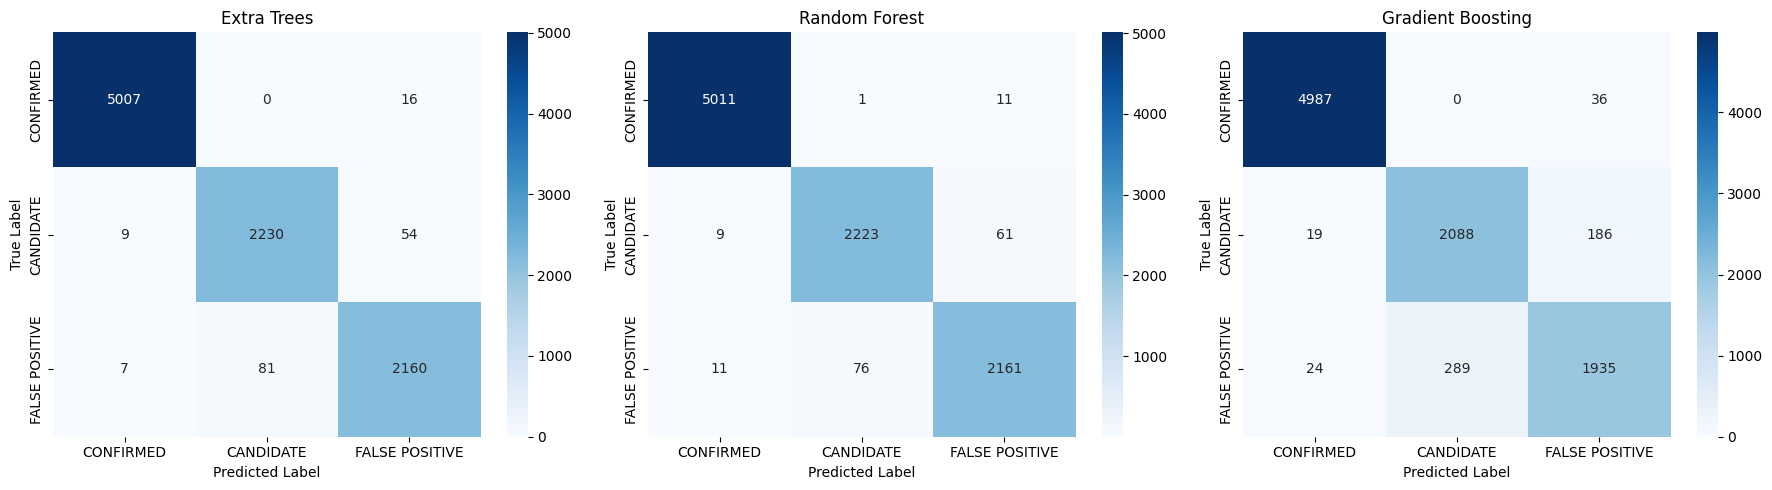

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

LABEL_ORDER = ["CONFIRMED", "CANDIDATE", "FALSE POSITIVE"]

# Plot confusion matrices for Top 3 models
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, model_name in zip(axes, TOP_3_MODEL_NAMES):
    pred_col = f"{model_name}_prediction"
    
    cm = confusion_matrix(
        results["True_Label"],
        results[pred_col],
        labels=LABEL_ORDER
    )
    
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=LABEL_ORDER,
        yticklabels=LABEL_ORDER,
        ax=ax
    )
    
    ax.set_title(f"{model_name}")
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")

plt.tight_layout()
plt.show()

### Confusion Matrix Interpretation (Top 3 Models)

- **Extra Trees** shows the strongest overall performance, with very high correct classification along the diagonal and minimal confusion between *CONFIRMED* and *FALSE POSITIVE*. Most errors occur in distinguishing *CANDIDATE* cases, which is expected due to their ambiguous nature.

- **Random Forest** performs similarly to Extra Trees, with slightly fewer misclassifications for *CONFIRMED* planets and comparable confusion in the *CANDIDATE* class. Its predictions are stable and well-balanced across all three classes.

- **Gradient Boosting** remains strong for *CONFIRMED* planets but exhibits noticeably higher confusion between *CANDIDATE* and *FALSE POSITIVE*. This indicates reduced reliability when handling borderline transit signals.

**Overall conclusion:**   
Tree-based ensemble models are highly effective for exoplanet disposition classification, with **Extra Trees** and **Random Forest** offering the most reliable and scientifically consistent predictions, while **CANDIDATE** cases remain the most challenging across all models.

## Testing top three models with unseen data again

In [30]:
# Define Top-3 Models
top3_models = {
    "Extra Trees": models["Extra Trees"],
    "Random Forest": models["Random Forest"],
    "Gradient Boosting": models["Gradient Boosting"]
}

In [31]:
# Prepare Unseen Test Data (STRICT). This ensures no data leakage.
# Split again to simulate unseen data
X_train_u, X_unseen, y_train_u, y_unseen = train_test_split(
    X,
    y_encoded,
    test_size=0.15,
    stratify=y_encoded,
    random_state=99
)

print("Unseen samples:", X_unseen.shape[0])

Unseen samples: 1435


In [32]:
# Scale Using NASA Standard Scaler (RE-FIT CORRECTLY)

nasa_scaler = StandardScaler()
X_train_u_scaled = nasa_scaler.fit_transform(X_train_u)
X_unseen_scaled = nasa_scaler.transform(X_unseen)

In [33]:
# Evaluate function
def evaluate_model(model, X_test, y_test):
    preds = model.predict(X_test)

    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(X_test)
        roc = roc_auc_score(y_test, proba, multi_class="ovr")
        confidence = np.max(proba, axis=1)
    else:
        roc = np.nan
        confidence = np.ones(len(preds))

    return {
        "Accuracy": accuracy_score(y_test, preds),
        "Precision": precision_score(y_test, preds, average="macro"),
        "Recall": recall_score(y_test, preds, average="macro"),
        "F1": f1_score(y_test, preds, average="macro"),
        "ROC-AUC": roc,
        "Predictions": preds,
        "Confidence": confidence
    }


In [34]:
# Run Unseen-Data Evaluation (Top 3)
unseen_results = {}

for name, model in top3_models.items():
    
    # Tree models DO NOT need scaling
    if name in ["Extra Trees", "Random Forest", "Gradient Boosting"]:
        metrics = evaluate_model(model, X_unseen, y_unseen)
    else:
        metrics = evaluate_model(model, X_unseen_scaled, y_unseen)
    
    unseen_results[name] = metrics

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 400 out of 400 | elapsed:    0.0s finished


In [35]:
# Summary Table
summary = pd.DataFrame({
    model: {
        "Accuracy": unseen_results[model]["Accuracy"],
        "Precision": unseen_results[model]["Precision"],
        "Recall": unseen_results[model]["Recall"],
        "F1-score": unseen_results[model]["F1"],
        "ROC-AUC": unseen_results[model]["ROC-AUC"]
    }
    for model in unseen_results
}).T

summary.sort_values("Accuracy", ascending=False)

,Accuracy,Precision,Recall,F1-score,ROC-AUC
Extra Trees,0.980488,0.974244,0.974694,0.974460,0.999049
Random Forest,0.980488,0.974219,0.974714,0.974466,0.997830
Gradient Boosting,0.937282,0.915337,0.915513,0.915311,0.989040


In [36]:
LABEL_MAP = {
    0: "FALSE POSITIVE",
    1: "CANDIDATE",
    2: "CONFIRMED"
}

demo_results = pd.DataFrame({
    "True_Label": y_unseen.map(LABEL_MAP)
})

for model in unseen_results:
    demo_results[f"{model}_Prediction"] = [
        LABEL_MAP[p] for p in unseen_results[model]["Predictions"]
    ]
    demo_results[f"{model}_Confidence"] = unseen_results[model]["Confidence"]

demo_results.head(15)

,True_Label,Extra Trees_Prediction,Extra Trees_Confidence,Random Forest_Prediction,Random Forest_Confidence,Gradient Boosting_Prediction,Gradient Boosting_Confidence
4012,CONFIRMED,CONFIRMED,1.000,CONFIRMED,1.000,CONFIRMED,0.997768
2173,FALSE POSITIVE,FALSE POSITIVE,1.000,FALSE POSITIVE,0.905,FALSE POSITIVE,0.877465
9181,FALSE POSITIVE,FALSE POSITIVE,1.000,FALSE POSITIVE,0.990,FALSE POSITIVE,0.982525
5659,CANDIDATE,CANDIDATE,1.000,CANDIDATE,0.855,CANDIDATE,0.745071
2501,CONFIRMED,CONFIRMED,1.000,CONFIRMED,0.995,CONFIRMED,0.998783
7797,CONFIRMED,CONFIRMED,1.000,CONFIRMED,0.990,CONFIRMED,0.992342
9275,FALSE POSITIVE,FALSE POSITIVE,1.000,FALSE POSITIVE,0.965,FALSE POSITIVE,0.957141
7105,FALSE POSITIVE,FALSE POSITIVE,1.000,FALSE POSITIVE,0.835,FALSE POSITIVE,0.639918
8341,FALSE POSITIVE,FALSE POSITIVE,1.000,FALSE POSITIVE,0.875,FALSE POSITIVE,0.863915
2996,CANDIDATE,CANDIDATE,1.000,CANDIDATE,0.940,CANDIDATE,0.962296


In [37]:
for model in top3_models:
    correct = (
        demo_results[f"{model}_Prediction"] == demo_results["True_Label"]
    ).mean()
    print(f"{model} unseen accuracy check: {correct:.3f}")

Extra Trees unseen accuracy check: 0.980
Random Forest unseen accuracy check: 0.980
Gradient Boosting unseen accuracy check: 0.937


In [38]:
MODELS_PATH = Path("../models/top_3")
MODELS_PATH.mkdir(exist_ok=True)

In [39]:
joblib.dump(nasa_scaler, MODELS_PATH / "nasa_standard_scaler.pkl")

print("NASA StandardScaler saved.")

NASA StandardScaler saved.


In [40]:
joblib.dump(top3_models["Extra Trees"], MODELS_PATH / "final_extra_trees.pkl")
joblib.dump(top3_models["Random Forest"], MODELS_PATH / "final_random_forest.pkl")
joblib.dump(top3_models["Gradient Boosting"], MODELS_PATH / "final_gradient_boosting.pkl")

print("Top 3 models saved successfully.")

Top 3 models saved successfully.


In [41]:
metadata = {
    "models": [
        "Extra Trees",
        "Random Forest",
        "Gradient Boosting"
    ],
    "features_used": list(X.columns),
    "label_mapping": LABEL_MAP,
    "scaler": "StandardScaler (NASA)",
    "training_split": "85% train / 15% unseen test",
    "random_state": 99
}

joblib.dump(metadata, MODELS_PATH / "final_model_metadata.pkl")

print("Model metadata saved.")

Model metadata saved.
